In [1]:
import torch
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Trainset
transform = transforms.ToTensor()
all_mnist_train = MNIST('data/', download=True, train=True, transform=transform)
mnist_train = Subset(all_mnist_train, range(10000))

# Testset
all_mnist_test = MNIST('data/', download=True, train=False, transform=transform)
mnist_test = Subset(all_mnist_test, range(6000))
len(mnist_train), len(mnist_test)

(10000, 6000)

In [3]:
# dataloader
num_workers = 0
batch_size = 20

mnist_trainset = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers)
mnist_testset = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers)
mnist_trainset

In [4]:
images, labels = next(iter(mnist_trainset))
images.shape, labels.shape

(torch.Size([20, 1, 28, 28]), torch.Size([20]))

In [9]:
def plot_images(images, labels=labels, col=2):
    num_images = len(images)
    
    row = int(np.ceil(num_images/col))
    col = col
    fig, axes = plt.subplots(row, col)
    
    for i in range(row):
        for j in range(col):
            if i*col+j < num_images:
                axes[i, j].imshow(np.squeeze(images[i*col+j]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'{labels[i*col+j].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

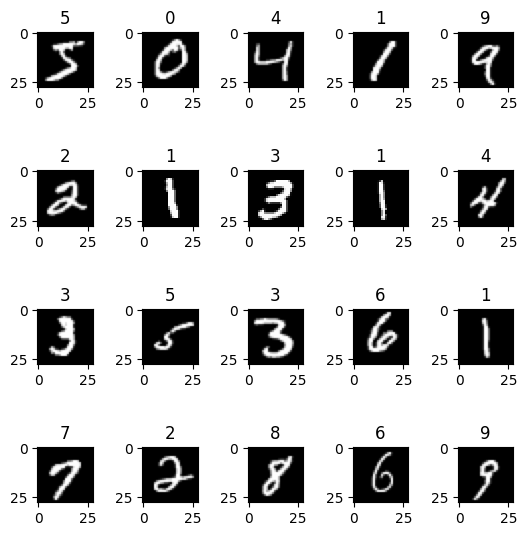

In [10]:
plot_images(images,labels=labels, col=5)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_size),
            nn.Sigmoid()
        )

    def forward(self, X):
        encoded = self.encoder(X)
        return self.decoder(encoded)

    def fit(self, X, lr=0.1, optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        if not type(all_mnist_train) == MNIST and not type(mnist_train) == Subset:
            raise Exception('the type of input dataset must be MNIST or Subset')

        # dataloader with batch size
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

        # optimizer and loss function
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()

        # Epoch
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0

            # mini batch for batch size
            for data in mnist_trainset:
                images, _ = data

                # init optimizer
                optimizer.zero_grad()

                # forward
                images = images.view(images.size(0), -1)
                y_hat = self.forward(images)

                # check error
                loss = loss_fn(y_hat, images)

                # backward and update
                loss.backward()
                optimizer.step()

                # print loss
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()*images.size(0):.6f}', end='\r')

                # add loss
                train_loss += loss.item()*images.size(0)
                batch_num += images.size(0)

            # average loss
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

    def predict_encoder(self, X, batch_size=128):
        if not type(all_mnist_train) == MNIST and not type(mnist_train) == Subset:
            raise Exception('the type of input dataset must be MNIST or Subset')
            
        result = torch.tensor([])
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)

        # mini batch for batch size
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)        
            result = torch.concat([result, self.encoder(images)], axis=0)           
        return result

    def predict_decoder(self, X):
        # X.shape: (N, latent_dim)
        X = torch.tensor(X, dtype=torch.float32)
        return self.decoder(X)

    def predict(self, X, batch_size=128):
        if not type(all_mnist_train) == MNIST and not type(mnist_train) == Subset:
            raise Exception('the type of input dataset must be MNIST or Subset')
            
        result = torch.tensor([])
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)

        # mini batch for batch size
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)        
            result = torch.concat([result, self.forward(images)], axis=0)
        return result

In [12]:
# autoencoder
ae = Autoencoder(28*28, 64)
ae

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [13]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [14]:
ae.apply(init_weights)
ae.fit(mnist_train, epochs=20, lr=0.001, batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 0.957566
Epoch: 2 [10000/10000], Loss: 0.446451
Epoch: 3 [10000/10000], Loss: 0.304675
Epoch: 4 [10000/10000], Loss: 0.228747
Epoch: 5 [10000/10000], Loss: 0.181448
Epoch: 6 [10000/10000], Loss: 0.151552
Epoch: 7 [10000/10000], Loss: 0.131870
Epoch: 8 [10000/10000], Loss: 0.118996
Epoch: 9 [10000/10000], Loss: 0.109840
Epoch: 10 [10000/10000], Loss: 0.103440
Epoch: 11 [10000/10000], Loss: 0.098682
Epoch: 12 [10000/10000], Loss: 0.094906
Epoch: 13 [10000/10000], Loss: 0.092126
Epoch: 14 [10000/10000], Loss: 0.089801
Epoch: 15 [10000/10000], Loss: 0.087895
Epoch: 16 [10000/10000], Loss: 0.086344
Epoch: 17 [10000/10000], Loss: 0.085130
Epoch: 18 [10000/10000], Loss: 0.083984
Epoch: 19 [10000/10000], Loss: 0.083052
Epoch: 20 [10000/10000], Loss: 0.082234


In [15]:
def plot_generated_images(generated_images, images, labels=labels):
    row = len(generated_images)
    col = 2
    fig, axes = plt.subplots(row, col)
    
    for i in range(row):
        for j in range(col):
            if j == 0:
                axes[i, j].imshow(np.squeeze(generated_images[i]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'Generated: {labels[i].item()}')
                continue
            axes[i, j].imshow(np.squeeze(images[i]), cmap='gray')
            if len(labels):
                axes[i, j].set_title(f'Original: {labels[i].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

In [16]:
reconstructed_images = ae.predict(mnist_test, batch_size=256)

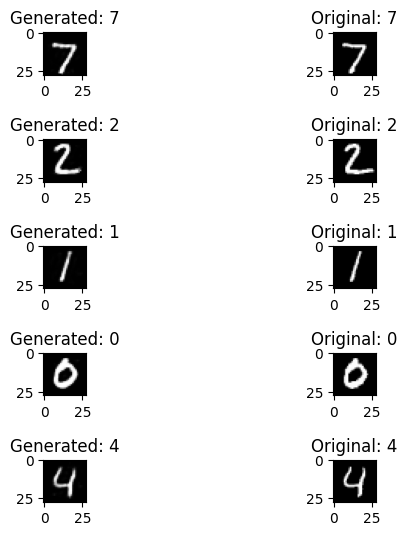

In [17]:
num = 5
plot_generated_images(reconstructed_images.detach().numpy().reshape(-1, 28, 28)[:num], all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num])

In [18]:
encoded_images = ae.predict_encoder(mnist_test, batch_size=256)
encoded_images.shape

torch.Size([6000, 64])

In [19]:
encoded_images

tensor([[ 3.8855,  8.3301,  9.7055,  ...,  1.7653,  1.0463,  4.4071],
        [ 6.0934,  0.0000,  3.5132,  ...,  5.1601, 10.7585,  4.9321],
        [ 0.1583,  4.8320,  1.2642,  ...,  4.6723,  1.4624,  4.2559],
        ...,
        [ 7.1966,  8.7953,  7.2403,  ...,  8.0325,  7.8989,  4.2804],
        [ 0.0000,  3.8928,  4.0589,  ...,  5.9875,  4.3686,  1.4140],
        [ 4.3243,  5.3682,  0.5886,  ...,  2.8987,  5.9292,  3.9988]],
       grad_fn=<CatBackward0>)

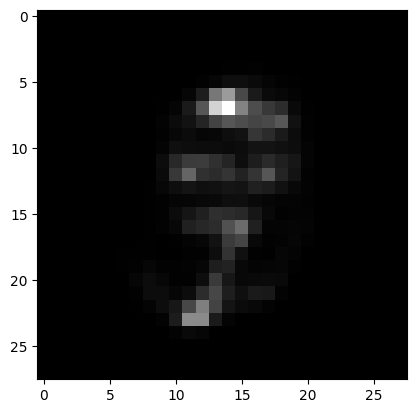

In [21]:
random_encoded_image = [np.mean(encoded_images[:, 0].detach().numpy()) for i in range(64)]
plt.imshow(ae.predict_decoder(random_encoded_image).detach().numpy().reshape(28, 28), cmap='gray')

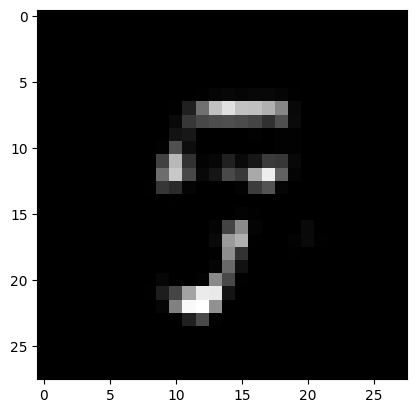

In [30]:
random_encoded_image = [np.random.uniform(5, 12) for i in range(64)]
plt.imshow(ae.predict_decoder(random_encoded_image).detach().numpy().reshape(28, 28), cmap='gray')

In [31]:
# Stacking Autoencoder

class SAE(nn.Module):
    def __init__(self, input_size, latent_dim, hidden_layers=[512, 128, 32]):
        super().__init__()
        self.encoder = self.encoder_net(input_size, latent_dim, hidden_layers)
        self.decoder = self.decoder_net(input_size, latent_dim, hidden_layers)
        
    def encoder_net(self, X_size, latent_dim, hidden_layers):
        encoder = nn.Sequential()
        if hidden_layers:
            for i in range(len(hidden_layers)):
                if i == 0:
                    encoder.append(nn.Linear(X_size, hidden_layers[i]))
                    encoder.append(nn.ReLU())
                    continue
                encoder.append(nn.Linear(hidden_layers[i-1],hidden_layers[i]))
                encoder.append(nn.ReLU())
            encoder.append(nn.Linear(hidden_layers[-1], latent_dim))
            encoder.append(nn.ReLU())
        else:
            encoder.append(nn.Linear(X_size, latent_dim))
            encoder.append(nn.ReLU())
        return encoder

    def decoder_net(self, X_size, latent_dim, hidden_layers):
        hidden_layers.reverse()
        decoder = nn.Sequential()
        if hidden_layers:
            for i in range(len(hidden_layers)):
                if i == 0:
                    decoder.append(nn.Linear(latent_dim, hidden_layers[i]))
                    decoder.append(nn.ReLU())
                    continue
                decoder.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
                decoder.append(nn.ReLU())
            decoder.append(nn.Linear(hidden_layers[-1], X_size))
            decoder.append(nn.Sigmoid())
        else:
            decoder.append(nn.Linear(latent_dim, X_size))
            decoder.append(nn.Sigmoid())
        return decoder


    def forward(self, X):
        return self.decoder(self.encoder(X))

    def fit(self, X, lr=0.1, optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()
        
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data    
                optimizer.zero_grad()
                
                images = images.view(images.size(0), -1)
                y_hat = self.forward(images)
                
                loss = loss_fn(y_hat, images)
                
                loss.backward()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()*images.size(0):.6f}', end='\r')
                train_loss += loss.item()*images.size(0)
                batch_num += images.size(0)
    
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

    def predict_encoder(self, X, batch_size=128):
        result = None
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)
        
            if i == 0:
                result = self.encoder(images)
                continue
            
            result = torch.concat([result, self.encoder(images)], axis=0)           
        return result

    def predict_decoder(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        return self.decoder(X)

    def predict(self, X, batch_size=128):
        result = None
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)
        
            if i == 0:
                result = self.forward(images)
                continue
            
            result = torch.concat([result, self.forward(images)], axis=0)
        return result

In [32]:
sae = SAE(28*28, 64, hidden_layers=[])
sae

SAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [33]:
sae = SAE(28*28, 64, hidden_layers=[512, 256, 128])
sae

SAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [34]:
sae.apply(init_weights)
sae.fit(mnist_train, epochs=20, lr=0.001, batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 0.917797
Epoch: 2 [10000/10000], Loss: 0.493638
Epoch: 3 [10000/10000], Loss: 0.389916
Epoch: 4 [10000/10000], Loss: 0.338272
Epoch: 5 [10000/10000], Loss: 0.304709
Epoch: 6 [10000/10000], Loss: 0.279436
Epoch: 7 [10000/10000], Loss: 0.260908
Epoch: 8 [10000/10000], Loss: 0.246004
Epoch: 9 [10000/10000], Loss: 0.235206
Epoch: 10 [10000/10000], Loss: 0.225931
Epoch: 11 [10000/10000], Loss: 0.216927
Epoch: 12 [10000/10000], Loss: 0.208792
Epoch: 13 [10000/10000], Loss: 0.201750
Epoch: 14 [10000/10000], Loss: 0.198527
Epoch: 15 [10000/10000], Loss: 0.191252
Epoch: 16 [10000/10000], Loss: 0.186948
Epoch: 17 [10000/10000], Loss: 0.182376
Epoch: 18 [10000/10000], Loss: 0.179227
Epoch: 19 [10000/10000], Loss: 0.177265
Epoch: 20 [10000/10000], Loss: 0.172543


In [35]:
reconstructed_images = sae.predict(mnist_test, batch_size=256)

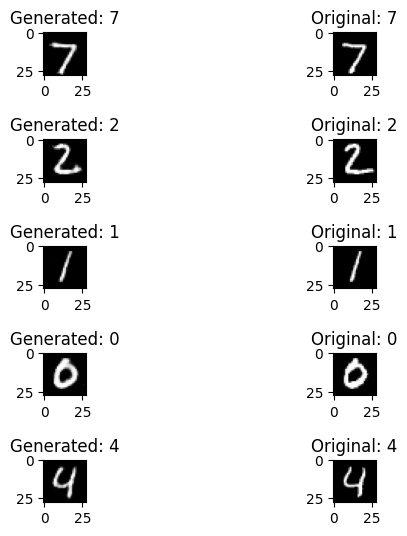

In [36]:
num = 5
plot_generated_images(reconstructed_images.detach().numpy().reshape(-1, 28, 28)[:num], all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num])

In [37]:
encoded_images = sae.predict_encoder(mnist_test, batch_size=256)
encoded_images.shape

torch.Size([6000, 64])

In [38]:
encoded_images

tensor([[0.0000, 2.7490, 4.3568,  ..., 0.0000, 0.0000, 1.4966],
        [0.0000, 5.7040, 7.8576,  ..., 0.0000, 0.0000, 5.1470],
        [0.0000, 3.1384, 9.6473,  ..., 0.0000, 0.0000, 4.3043],
        ...,
        [0.0000, 1.4948, 4.1254,  ..., 0.0000, 0.0000, 7.0168],
        [0.0000, 3.2979, 3.1424,  ..., 0.0000, 0.0000, 0.0481],
        [0.0000, 5.3761, 7.5452,  ..., 0.0000, 0.0000, 0.9731]],
       grad_fn=<CatBackward0>)

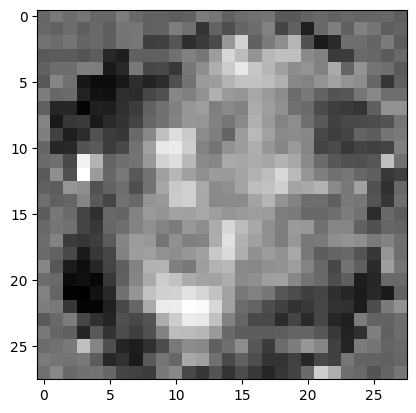

In [39]:
random_encoded_image = [np.mean(encoded_images[:, 0].detach().numpy()) for i in range(64)]
plt.imshow(sae.predict_decoder(random_encoded_image).detach().numpy().reshape(28, 28), cmap='gray')

In [40]:
sae_2 = SAE(28*28, 2, hidden_layers=[512, 128, 32])
sae_2

SAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [64]:
sae_2.apply(init_weights)
sae_2.fit(mnist_train, epochs=20, lr=0.001, batch_size=20, optimizer='NAdam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.322519
Epoch: 2 [10000/10000], Loss: 1.061931
Epoch: 3 [10000/10000], Loss: 0.938959
Epoch: 4 [10000/10000], Loss: 0.890670
Epoch: 5 [10000/10000], Loss: 0.858493
Epoch: 6 [10000/10000], Loss: 0.835875
Epoch: 7 [10000/10000], Loss: 0.822443
Epoch: 8 [10000/10000], Loss: 0.808437
Epoch: 9 [10000/10000], Loss: 0.794797
Epoch: 10 [10000/10000], Loss: 0.783378
Epoch: 11 [10000/10000], Loss: 0.786915
Epoch: 12 [10000/10000], Loss: 0.771957
Epoch: 13 [10000/10000], Loss: 0.760649
Epoch: 14 [10000/10000], Loss: 0.759096
Epoch: 15 [10000/10000], Loss: 0.752943
Epoch: 16 [10000/10000], Loss: 0.750192
Epoch: 17 [10000/10000], Loss: 0.746209
Epoch: 18 [10000/10000], Loss: 0.743946
Epoch: 19 [10000/10000], Loss: 0.733287
Epoch: 20 [10000/10000], Loss: 0.725370


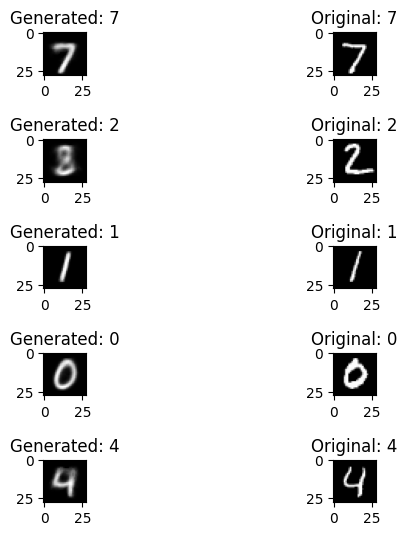

In [65]:
num = 5
reconstructed_images = sae_2.predict(mnist_test, batch_size=256)
plot_generated_images(reconstructed_images.detach().numpy().reshape(-1, 28, 28)[:num], all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num])

In [66]:
encoded_images = sae_2.predict_encoder(mnist_test, batch_size=256)
encoded_images.shape

torch.Size([6000, 2])

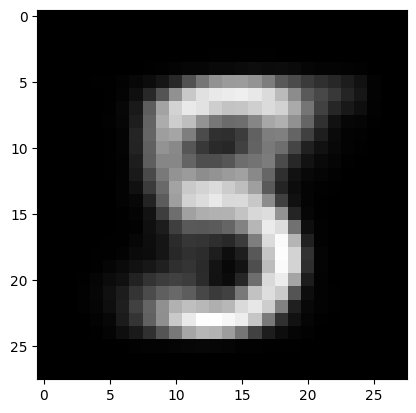

In [67]:
random_encoded_image = [np.mean(encoded_images[:, 0].detach().numpy()) for i in range(2)]
plt.imshow(sae_2.predict_decoder(random_encoded_image).detach().numpy().reshape(28, 28), cmap='gray')

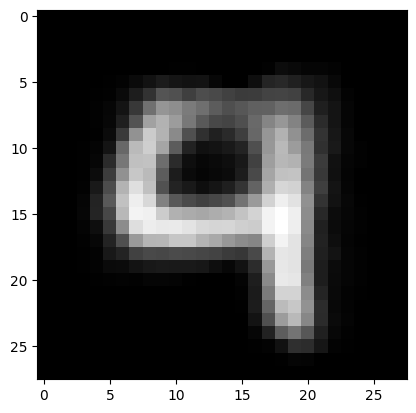

In [70]:
plt.imshow(sae_2.predict_decoder([np.random.uniform(0,1), np.random.uniform(0,1)]).detach().numpy().reshape(28, 28), cmap='gray')

In [71]:
def perturb_iterative(X, y, steps=10, dec=None, save=False):
    """
    For a large number of steps, generate the grid iteratively
    """
    from scipy.stats import norm
    
    # Generate samples from the support of p(z)
    x = np.linspace(0.01, 0.99, num=steps)
    y = np.linspace(0.01, 0.99, num=steps)
    l_x = x.shape[0]
    l_y = y.shape[0]
    x_grid = np.repeat(x, l_y).reshape(-1, 1)
    y_grid = np.tile(y, l_x).reshape(-1, 1)
    _z = np.concatenate([x_grid, y_grid], axis=1)
    
    grid = np.zeros((x.shape[0]*28, y.shape[0]*28))
    n_rows, n_cols = grid.shape

    images_l = []
    for i, k in enumerate(range(_z.shape[0])):
        dim = _z[k]
        images_l.append(dec([dim]).detach().numpy().reshape(28,28))

    ptr = 0
    for i, _x in enumerate(x): # -1, -1, ..0, 0, 
        for j, _x in enumerate(x): # -1, 0, 1,
        
            _img = images_l[ptr]
            grid[n_rows-(j*28+28):n_rows-j*28, i*28:i*28+28] = _img

            ptr += 1
    f = plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

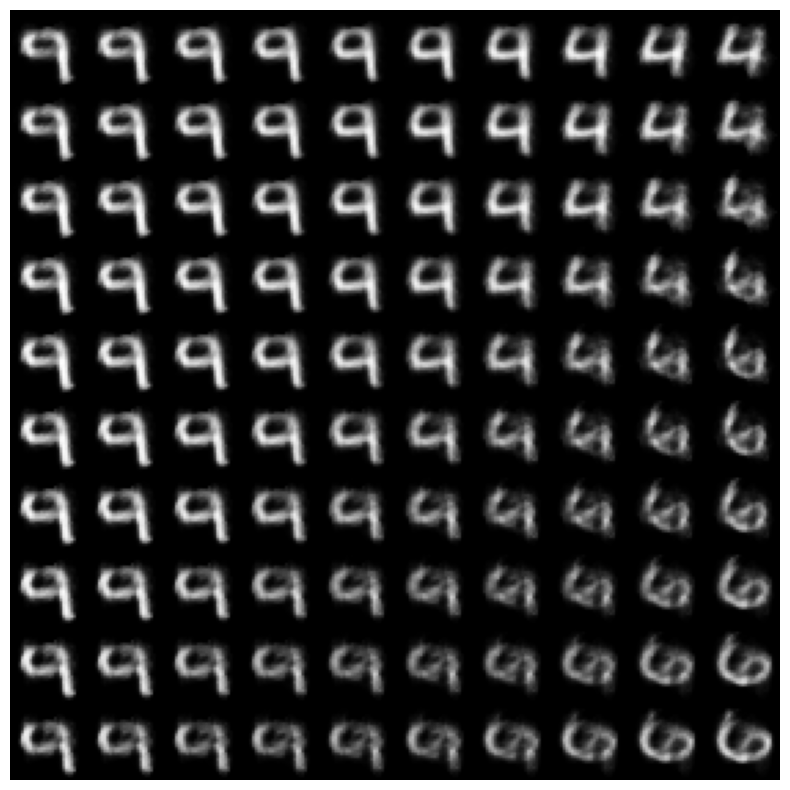

In [72]:
perturb_iterative(all_mnist_test.data, all_mnist_test.targets, steps=10, dec=sae_2.predict_decoder)